In [7]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot as plt
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from tensorflow import keras
from keras.models import model_from_json
import numpy as np
import pandas as pd
import time
import tensorflow as tf

In [8]:
# datos: secuencia de observaciones como una lista o matriz 2D NumPy. Necesario.
# n_in: Número de observaciones de retraso como entrada (X). Los valores pueden estar entre [1..len (datos)] Opcional. El valor predeterminado es 1.
# n_out: Número de observaciones como salida (y). Los valores pueden estar entre [0..len (datos) -1]. Opcional. Por defecto es 1.
# dropnan: booleano si se deben soltar o no filas con valores NaN. Opcional. Por defecto es verdadero.


def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
# observaciones pasadas  (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
# tiempos futuros  (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    agg = concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [9]:
#Modelo de 12 carateristicas.

data = pd.read_excel('../PreparacionDatos/FloraTotal.xlsx' , sheet_name='FloraTotal' ,header=0)
data = data.drop(data.columns[[0]], axis=1) 

#Ordeno de primero el PM10
new_order = [8,1,2,3,4,5,6,0,7,9,10,11,12]
data = data[data.columns[new_order]]

data.describe()

,PM10,DirVien,H2S,Humedad,Lluvia,Motos_vehiculos_particulares,NO2,CO,O3,Poblacion,RSolar,SO2,Temp
count,8745.000000,8745.000000,8745.0,8745.000000,8745.000000,8745.000000,8745.000000,8745.000000,8745.000000,8.745000e+03,8745.000000,8745.000000,8745.000000
mean,26.791206,165.549339,0.0,73.829917,0.393544,370553.058205,17.648530,1334.647888,23.094041,2.257657e+06,152.349769,16.116981,24.154810
std,20.088073,102.419191,0.0,15.172316,2.767783,22650.978956,14.761252,756.503036,28.706740,1.311136e+04,219.520964,18.718881,4.573652
min,0.000000,0.000000,0.0,0.000000,0.000000,348066.000000,0.000000,0.000000,0.000000,2.244668e+06,0.000000,0.000000,0.000000
25%,10.900000,70.599998,0.0,61.000000,0.000000,348066.000000,0.000000,869.296875,4.843800,2.244668e+06,0.000000,6.911400,21.700001
50%,22.700001,157.800003,0.0,76.000000,0.000000,391327.000000,17.919701,1292.364258,9.241700,2.269653e+06,4.100000,10.784500,23.500000
75%,38.500000,257.799988,0.0,86.000000,0.000000,391327.000000,26.423599,1783.514648,30.708500,2.269653e+06,276.700012,17.833300,26.500000
max,149.699997,360.000000,0.0,339.000000,82.040001,630478.000000,124.501801,3703.348877,181.169403,2.420114e+06,927.700012,286.557892,339.000000


In [10]:
#Modelo de 12 carateristicas, borro las caracteticas.

data=data.drop(['Motos_vehiculos_particulares'], axis=1)
data=data.drop(['Poblacion'], axis=1)
data.reset_index()

,index,PM10,DirVien,H2S,Humedad,Lluvia,NO2,CO,O3,RSolar,SO2,Temp
0,0,2.600000,176.100006,0,70.099998,0.0000,0.0,391.467102,21.635599,0.000000,5.7409,24.400000
1,1,16.299999,149.000000,0,76.400002,0.0000,0.0,708.846497,11.241300,0.000000,7.7142,23.500000
2,2,9.800000,144.000000,0,79.099998,0.0000,0.0,683.904480,8.239500,0.000000,5.1359,22.700001
3,3,6.500000,197.199997,0,81.400002,0.0000,0.0,841.206421,7.457900,0.000000,6.7601,22.600000
4,4,9.000000,29.299999,0,86.400002,0.0000,0.0,681.828613,6.949200,0.000000,5.7961,21.900000
...,...,...,...,...,...,...,...,...,...,...,...,...
8740,8740,0.802300,0.038700,0,0.038700,0.8946,0.0,0.000000,0.000000,0.038700,0.0000,0.038700
8741,8741,23.094616,0.000000,0,0.000000,0.0000,0.0,0.000000,10.964662,0.000000,0.0000,0.000000
8742,8742,0.929000,0.000000,0,0.000000,0.9921,0.0,0.000000,0.216500,0.000000,0.0000,0.000000
8743,8743,23.094616,0.000000,0,0.000000,0.0000,0.0,0.000000,10.964662,42.267879,0.0000,0.000000


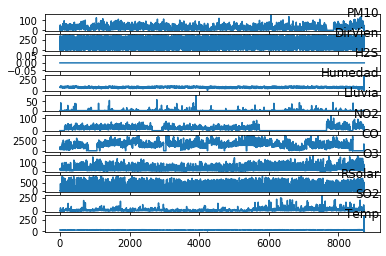

<Figure size 1728x432 with 0 Axes>

In [11]:
# Reprecentacion de los datos.
from matplotlib import pyplot
groups = [0,1,2,3,4,5,6,7,8,9,10]
i = 1
values = data.values
pyplot.figure()
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
    pyplot.title(data.columns[group], y=0.5, loc='right')
    i += 1
pyplot.figure(figsize=(24,6))
pyplot.show()

In [12]:
data.describe()

,PM10,DirVien,H2S,Humedad,Lluvia,NO2,CO,O3,RSolar,SO2,Temp
count,8745.000000,8745.000000,8745.0,8745.000000,8745.000000,8745.000000,8745.000000,8745.000000,8745.000000,8745.000000,8745.000000
mean,26.791206,165.549339,0.0,73.829917,0.393544,17.648530,1334.647888,23.094041,152.349769,16.116981,24.154810
std,20.088073,102.419191,0.0,15.172316,2.767783,14.761252,756.503036,28.706740,219.520964,18.718881,4.573652
min,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,10.900000,70.599998,0.0,61.000000,0.000000,0.000000,869.296875,4.843800,0.000000,6.911400,21.700001
50%,22.700001,157.800003,0.0,76.000000,0.000000,17.919701,1292.364258,9.241700,4.100000,10.784500,23.500000
75%,38.500000,257.799988,0.0,86.000000,0.000000,26.423599,1783.514648,30.708500,276.700012,17.833300,26.500000
max,149.699997,360.000000,0.0,339.000000,82.040001,124.501801,3703.348877,181.169403,927.700012,286.557892,339.000000


In [13]:
values[:,8]

array([ 0.        ,  0.        ,  0.        , ...,  0.        ,
       42.26787949,  0.49219999])

In [14]:
#values = data.values

# integer encode direction

#codifica etiquetas de una característica categórica en valores numéricos entre 0 y el número de clases menos 1.
#Una vez instanciado, el método fit lo entrena (creando el mapeado entre las etiquetas y los números)
#y el método transform transforma las etiquetas que se incluyan como argumento en los números correspondientes.

#encoder = LabelEncoder()
#valuesEncoder=encoder.fit_transform(values[:,0])

In [16]:
values = data.values

#Normalize features(0,1)
#Este estimador escala y traduce cada característica
#individualmente de modo que esté en el rango dado en el conjunto de entrenamiento
#https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [17]:
scaled[:,7]

array([0.11942193, 0.06204855, 0.04547953, ..., 0.00119501, 0.0605216 ,
       0.00462882])

In [18]:

reframed = series_to_supervised(scaled, 1, 1)

print(reframed.head())


   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.017368   0.489167        0.0   0.206785        0.0        0.0   
2   0.108884   0.413889        0.0   0.225369        0.0        0.0   
3   0.065464   0.400000        0.0   0.233333        0.0        0.0   
4   0.043420   0.547778        0.0   0.240118        0.0        0.0   
5   0.060120   0.081389        0.0   0.254867        0.0        0.0   

   var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)  ...   var2(t)  var3(t)  \
1   0.105706   0.119422        0.0    0.020034  ...  0.413889      0.0   
2   0.191407   0.062049        0.0    0.026920  ...  0.400000      0.0   
3   0.184672   0.045480        0.0    0.017923  ...  0.547778      0.0   
4   0.227147   0.041165        0.0    0.023591  ...  0.081389      0.0   
5   0.184111   0.038357        0.0    0.020227  ...  0.022222      0.0   

    var4(t)  var5(t)  var6(t)   var7(t)   var8(t)  var9(t)  var10(t)  var11(t)  
1  0.225369      0.0      0.0  0.191407  0.0620

In [19]:
reframed.columns

Index(['var1(t-1)', 'var2(t-1)', 'var3(t-1)', 'var4(t-1)', 'var5(t-1)',
       'var6(t-1)', 'var7(t-1)', 'var8(t-1)', 'var9(t-1)', 'var10(t-1)',
       'var11(t-1)', 'var1(t)', 'var2(t)', 'var3(t)', 'var4(t)', 'var5(t)',
       'var6(t)', 'var7(t)', 'var8(t)', 'var9(t)', 'var10(t)', 'var11(t)'],
      dtype='object')

In [20]:
#Dejo la variable objetico en PM10 (T) y y todas (T-1)...................
reframed.drop(reframed.columns[[12,13,14,15,16,17,18,19,20,21]], axis=1, inplace=True)
 
#Dejo la variable objetico en PM10 (T) y las demas en (T-1)...................
#reframed.drop(reframed.columns[[12,14,15,16,17,18,19,20,21,22,23,24,25]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.017368   0.489167        0.0   0.206785        0.0        0.0   
2   0.108884   0.413889        0.0   0.225369        0.0        0.0   
3   0.065464   0.400000        0.0   0.233333        0.0        0.0   
4   0.043420   0.547778        0.0   0.240118        0.0        0.0   
5   0.060120   0.081389        0.0   0.254867        0.0        0.0   

   var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)  var11(t-1)   var1(t)  
1   0.105706   0.119422        0.0    0.020034    0.071976  0.108884  
2   0.191407   0.062049        0.0    0.026920    0.069322  0.065464  
3   0.184672   0.045480        0.0    0.017923    0.066962  0.043420  
4   0.227147   0.041165        0.0    0.023591    0.066667  0.060120  
5   0.184111   0.038357        0.0    0.020227    0.064602  0.103540  


In [21]:
reframed.columns

Index(['var1(t-1)', 'var2(t-1)', 'var3(t-1)', 'var4(t-1)', 'var5(t-1)',
       'var6(t-1)', 'var7(t-1)', 'var8(t-1)', 'var9(t-1)', 'var10(t-1)',
       'var11(t-1)', 'var1(t)'],
      dtype='object')

In [22]:
values = reframed.values

#Datos de entrenamiento y pruebas:
n_train_hours = 4000
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]


In [23]:
train[:, 0:11]

array([[0.01736807, 0.48916668, 0.        , ..., 0.        , 0.020034  ,
        0.0719764 ],
       [0.10888443, 0.41388889, 0.        , ..., 0.        , 0.02692021,
        0.06932153],
       [0.06546426, 0.4       , 0.        , ..., 0.        , 0.01792273,
        0.06696165],
       ...,
       [0.44221776, 0.29666668, 0.        , ..., 0.        , 0.03132142,
        0.07079646],
       [0.57381432, 0.32055556, 0.        , ..., 0.        , 0.03946009,
        0.06873156],
       [0.50501002, 0.44194446, 0.        , ..., 0.        , 0.04618578,
        0.06519174]])

In [24]:
# Datos de entrada y de salida.
train_X, train_y = train[:, :-1], train[:, -1:]
test_X, test_y = test[:, :-1], test[:, -1:]


#Remodelar la entrada para que sea 3D [muestras, pasos de tiempo, características]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(4000, 1, 11) (4000, 1) (4744, 1, 11) (4744, 1)


In [25]:
#Diseñando la red neuronal.
model = Sequential()

#Capa de entrada (unidades, 1, 12)
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))

#Capa de salida.
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
model.name="LTSM_cali"

#fit(x=None, y=None, batch_size=None, epochs=1, 
#verbose=1, callbacks=None, validation_split=0.0, validation_data=None, 
#shuffle=True, class_weight=None, sample_weight=None, initial_epoch=0, steps_per_epoch=None,
#validation_steps=None, validation_freq=1, max_queue_size=10, workers=1, use_multiprocessing=False)

model.summary()






_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50)                12400     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 12,451
Trainable params: 12,451
Non-trainable params: 0
_________________________________________________________________


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 4000 samples, validate on 4744 samples
Epoch 1/50





 - 1s - loss: 0.1105 - val_loss: 0.1002
Epoch 2/50
 - 0s - loss: 0.0915 - val_loss: 0.0910
Epoch 3/50
 - 0s - loss: 0.0822 - val_loss: 0.0844
Epoch 4/50
 - 0s - loss: 0.0749 - val_loss: 0.0757
Epoch 5/50
 - 0s - loss: 0.0692 - val_loss: 0.0687
Epoch 6/50
 - 0s - loss: 0.0658 - val_loss: 0.0653
Epoch 7/50
 - 0s - loss: 0.0642 - val_loss: 0.0632
Epoch 8/50
 - 0s - loss: 0.0636 - val_loss: 0.0620
Epoch 9/50
 - 0s - loss: 0.0632 - val_loss: 0.0614
Epoch 10/50
 - 0s - loss: 0.0631 - val_loss: 0.0613
Epoch 11/50
 - 0s - loss: 0.0630 - val_loss: 0.0612
Epoch 12/50
 - 0s - loss: 0.0629 - val_loss: 0.0610
Epoch 13/50
 - 0s - loss: 0.0628 - val_loss: 0.0610
Epoch 14/50
 - 0s - loss: 0.0627 - val_loss: 0.0610
Epoch 15/50
 - 0s - loss: 0.0627 - val_loss: 0.0610
Epoch 16/50
 - 0s - loss: 0.0626 - val_loss: 0.0610
Epoch 17/50
 - 0s - loss: 0

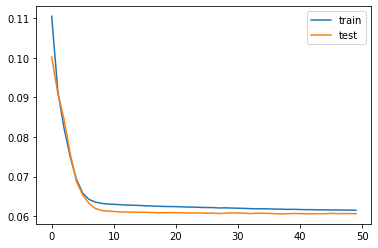

In [26]:

# Ajustado el modelo
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# Seguimiento al modelo 
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [27]:
yhat = model.predict(test_X)
test_X.shape

(4744, 1, 11)

In [28]:
# Realizo la prediccion.

test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
test_X.shape

(4744, 11)

In [170]:
test_X[:, :1]

array([[0.76276975],
       [0.679138  ],
       [0.59207127],
       ...,
       [0.        ],
       [0.        ],
       [0.        ]])

In [30]:
# invierco el scalar de la prediccion
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
#Invierco el scalar de los dato realizes
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calcular RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 12.880


In [143]:
# Vuelvo el modelo un archivo .json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
    

# Guardar el Modelo
model.save_weights('../Modelamiento/LTSM_Cali.h5')

In [144]:
model

In [40]:
train.shape

(4000, 14)